<a href="https://colab.research.google.com/github/zeliz22/Facial-Expression/blob/main/AdvancedEmotionNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!  pip install kaggle
! pip install wandb
!wandb login

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zeliz22 (zeliz22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zazaelizbarashvili","key":"3422f18d69545d5f43297b0e7bfb79f8"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip


 99% 283M/285M [00:00<00:00, 391MB/s]
100% 285M/285M [00:00<00:00, 405MB/s]
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


Using device: cuda
Training data shape: (28709, 2)
Test data shape: (7178, 1)
Unique emotions: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]

Emotion distribution:
0 (Angry): 3995
1 (Disgust): 436
2 (Fear): 4097
3 (Happy): 7215
4 (Sad): 4830
5 (Surprise): 3171
6 (Neutral): 4965


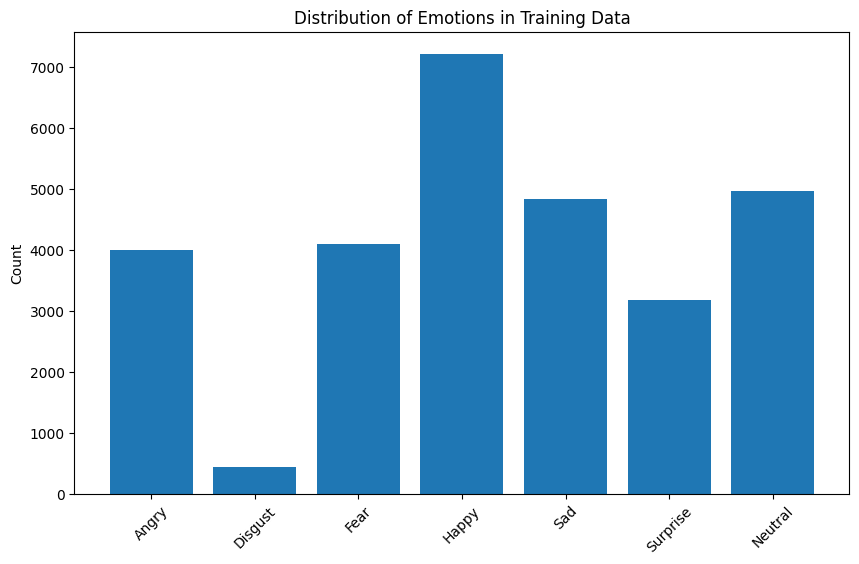

In [5]:
# Cell 1: Setup and Data Loading
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the data
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Unique emotions: {sorted(train_df['emotion'].unique())}")

# Check class distribution
emotion_counts = train_df['emotion'].value_counts().sort_index()
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
print("\nEmotion distribution:")
for i, count in emotion_counts.items():
    print(f"{i} ({emotion_labels[i]}): {count}")

# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.bar(range(7), emotion_counts.values)
plt.xticks(range(7), emotion_labels, rotation=45)
plt.title('Distribution of Emotions in Training Data')
plt.ylabel('Count')
plt.show()

In [6]:
# Cell 2: Custom Dataset and Data Transformation
from torchvision import transforms

class FacialExpressionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.pixels = df['pixels'].apply(lambda x: np.array(x.split(' '), dtype=np.uint8).reshape(48, 48)).tolist()
        self.emotions = df['emotion'].tolist() if 'emotion' in df.columns else None

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.pixels[idx]
        image = Image.fromarray(image) # Convert numpy array to PIL Image for torchvision transforms

        if self.transform:
            image = self.transform(image)

        if self.emotions is not None:
            emotion = self.emotions[idx]
            return image, torch.tensor(emotion, dtype=torch.long)
        else:
            return image

# Define transformations
# Training transforms with augmentation
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.Grayscale(num_output_channels=1), # Ensure grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # Normalize pixel values to [-1, 1]
])

# Validation/Test transforms (no augmentation, just normalization)
val_test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # Ensure grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # Normalize pixel values to [-1, 1]
])

In [7]:
# Cell 3: Data Splitting and DataLoader Creation
from PIL import Image # Import PIL Image for torchvision transforms

# Split training data for validation
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['emotion'])

# Create datasets
train_dataset = FacialExpressionDataset(train_data, transform=train_transforms)
val_dataset = FacialExpressionDataset(val_data, transform=val_test_transforms)
test_dataset = FacialExpressionDataset(test_df, transform=val_test_transforms) # For actual Kaggle submission

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True) # For actual Kaggle submission

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

# Example of a transformed image
# for images, labels in train_loader:
#     print(f"Image batch shape: {images.shape}")
#     print(f"Label batch shape: {labels.shape}")
#     plt.imshow(images[0].squeeze().cpu().numpy(), cmap='gray')
#     plt.title(f"Example transformed image (emotion: {labels[0].item()})")
#     plt.show()
#     break

Number of training samples: 22967
Number of validation samples: 5742
Number of test samples: 7178


In [8]:
# Cell 4: Define the CNN Model
class ComplexCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(ComplexCNN, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        # Block 2
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        # Block 3
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.25)

        # Fully Connected Layers
        # Calculate input features to the first FC layer
        # 48x48 image -> 24x24 (pool1) -> 12x12 (pool2) -> 6x6 (pool3)
        self.fc1 = nn.Linear(256 * 6 * 6, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout_fc1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully Connected Layers
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc1(x)
        x = self.fc2(x)
        return x

model = ComplexCNN(num_classes=7).to(device)
print(model)

ComplexCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1,

In [12]:
# Cell 5: Training Function
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(model, train_loader, val_loader, epochs, learning_rate, patience=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (Train)"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = correct_train / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} (Val)"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = correct_val / total_val
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

        # Learning rate scheduler step
        scheduler.step(epoch_val_acc)

        # Early stopping check
        if epoch_val_acc > best_val_accuracy:
            best_val_accuracy = epoch_val_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth') # Save the best model
            print("Best validation accuracy achieved. Model saved.")
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping triggered after {patience} epochs with no improvement.")
                break
    return history


In [13]:
# Cell 6: Run Training
epochs = 50 # You might need to increase this, but early stopping will manage it
learning_rate = 0.001

print(f"Starting training for {epochs} epochs with learning rate {learning_rate}...")
history = train_model(model, train_loader, val_loader, epochs, learning_rate, patience=10)

Starting training for 50 epochs with learning rate 0.001...


Epoch 1/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 60.03it/s]


Epoch 1/50 - Train Loss: 1.6877, Train Acc: 0.3313, Val Loss: 1.4135, Val Acc: 0.4587
Best validation accuracy achieved. Model saved.


Epoch 2/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 61.52it/s]


Epoch 2/50 - Train Loss: 1.4098, Train Acc: 0.4540, Val Loss: 1.2428, Val Acc: 0.5225
Best validation accuracy achieved. Model saved.


Epoch 3/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 61.67it/s]


Epoch 3/50 - Train Loss: 1.3046, Train Acc: 0.5009, Val Loss: 1.2305, Val Acc: 0.5345
Best validation accuracy achieved. Model saved.


Epoch 4/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 62.09it/s]


Epoch 4/50 - Train Loss: 1.2684, Train Acc: 0.5169, Val Loss: 1.1457, Val Acc: 0.5650
Best validation accuracy achieved. Model saved.


Epoch 5/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 62.47it/s]


Epoch 5/50 - Train Loss: 1.2211, Train Acc: 0.5359, Val Loss: 1.0896, Val Acc: 0.5871
Best validation accuracy achieved. Model saved.


Epoch 6/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 60.09it/s]


Epoch 6/50 - Train Loss: 1.1822, Train Acc: 0.5501, Val Loss: 1.0612, Val Acc: 0.5987
Best validation accuracy achieved. Model saved.


Epoch 7/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 57.89it/s]


Epoch 7/50 - Train Loss: 1.1629, Train Acc: 0.5571, Val Loss: 1.0580, Val Acc: 0.5974


Epoch 8/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 49.23it/s]


Epoch 8/50 - Train Loss: 1.1400, Train Acc: 0.5702, Val Loss: 1.0674, Val Acc: 0.5904


Epoch 9/50 (Val): 100%|██████████| 90/90 [00:02<00:00, 38.02it/s]


Epoch 9/50 - Train Loss: 1.1179, Train Acc: 0.5739, Val Loss: 1.0285, Val Acc: 0.6064
Best validation accuracy achieved. Model saved.


Epoch 10/50 (Val): 100%|██████████| 90/90 [00:02<00:00, 36.75it/s]


Epoch 10/50 - Train Loss: 1.0920, Train Acc: 0.5871, Val Loss: 1.0378, Val Acc: 0.6080
Best validation accuracy achieved. Model saved.


Epoch 11/50 (Val): 100%|██████████| 90/90 [00:02<00:00, 41.46it/s]


Epoch 11/50 - Train Loss: 1.0818, Train Acc: 0.5920, Val Loss: 1.0771, Val Acc: 0.6000


Epoch 12/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 51.54it/s]


Epoch 12/50 - Train Loss: 1.0664, Train Acc: 0.5987, Val Loss: 0.9977, Val Acc: 0.6172
Best validation accuracy achieved. Model saved.


Epoch 13/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 60.26it/s]


Epoch 13/50 - Train Loss: 1.0576, Train Acc: 0.6002, Val Loss: 0.9840, Val Acc: 0.6238
Best validation accuracy achieved. Model saved.


Epoch 14/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 60.02it/s]


Epoch 14/50 - Train Loss: 1.0444, Train Acc: 0.6067, Val Loss: 0.9531, Val Acc: 0.6418
Best validation accuracy achieved. Model saved.


Epoch 15/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 60.65it/s]


Epoch 15/50 - Train Loss: 1.0352, Train Acc: 0.6126, Val Loss: 0.9642, Val Acc: 0.6358


Epoch 16/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 60.42it/s]


Epoch 16/50 - Train Loss: 1.0171, Train Acc: 0.6162, Val Loss: 0.9468, Val Acc: 0.6407


Epoch 17/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 59.56it/s]


Epoch 17/50 - Train Loss: 1.0139, Train Acc: 0.6195, Val Loss: 0.9276, Val Acc: 0.6480
Best validation accuracy achieved. Model saved.


Epoch 18/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 60.72it/s]


Epoch 18/50 - Train Loss: 0.9978, Train Acc: 0.6219, Val Loss: 0.9645, Val Acc: 0.6348


Epoch 19/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 59.99it/s]


Epoch 19/50 - Train Loss: 0.9795, Train Acc: 0.6305, Val Loss: 0.9326, Val Acc: 0.6480


Epoch 20/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 60.32it/s]


Epoch 20/50 - Train Loss: 0.9761, Train Acc: 0.6335, Val Loss: 0.9209, Val Acc: 0.6588
Best validation accuracy achieved. Model saved.


Epoch 21/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 60.66it/s]


Epoch 21/50 - Train Loss: 0.9668, Train Acc: 0.6333, Val Loss: 0.9158, Val Acc: 0.6587


Epoch 22/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 59.74it/s]


Epoch 22/50 - Train Loss: 0.9606, Train Acc: 0.6364, Val Loss: 0.9015, Val Acc: 0.6609
Best validation accuracy achieved. Model saved.


Epoch 23/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 59.17it/s]


Epoch 23/50 - Train Loss: 0.9477, Train Acc: 0.6448, Val Loss: 0.9086, Val Acc: 0.6569


Epoch 24/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 58.12it/s]


Epoch 24/50 - Train Loss: 0.9369, Train Acc: 0.6474, Val Loss: 0.9135, Val Acc: 0.6574


Epoch 25/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 59.15it/s]


Epoch 25/50 - Train Loss: 0.9367, Train Acc: 0.6486, Val Loss: 0.9066, Val Acc: 0.6625
Best validation accuracy achieved. Model saved.


Epoch 26/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 49.10it/s]


Epoch 26/50 - Train Loss: 0.9214, Train Acc: 0.6574, Val Loss: 0.9151, Val Acc: 0.6571


Epoch 27/50 (Val): 100%|██████████| 90/90 [00:02<00:00, 40.48it/s]


Epoch 27/50 - Train Loss: 0.9128, Train Acc: 0.6555, Val Loss: 0.9090, Val Acc: 0.6628
Best validation accuracy achieved. Model saved.


Epoch 28/50 (Val): 100%|██████████| 90/90 [00:02<00:00, 38.54it/s]


Epoch 28/50 - Train Loss: 0.9058, Train Acc: 0.6603, Val Loss: 0.9067, Val Acc: 0.6604


Epoch 29/50 (Val): 100%|██████████| 90/90 [00:02<00:00, 38.37it/s]


Epoch 29/50 - Train Loss: 0.8905, Train Acc: 0.6632, Val Loss: 0.9160, Val Acc: 0.6592


Epoch 30/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 45.02it/s]


Epoch 30/50 - Train Loss: 0.8897, Train Acc: 0.6663, Val Loss: 0.8870, Val Acc: 0.6667
Best validation accuracy achieved. Model saved.


Epoch 31/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 60.47it/s]


Epoch 31/50 - Train Loss: 0.8860, Train Acc: 0.6691, Val Loss: 0.8894, Val Acc: 0.6681
Best validation accuracy achieved. Model saved.


Epoch 32/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 60.17it/s]


Epoch 32/50 - Train Loss: 0.8717, Train Acc: 0.6735, Val Loss: 0.8838, Val Acc: 0.6708
Best validation accuracy achieved. Model saved.


Epoch 33/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 60.90it/s]


Epoch 33/50 - Train Loss: 0.8614, Train Acc: 0.6781, Val Loss: 0.8820, Val Acc: 0.6724
Best validation accuracy achieved. Model saved.


Epoch 34/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 58.69it/s]


Epoch 34/50 - Train Loss: 0.8532, Train Acc: 0.6780, Val Loss: 0.8918, Val Acc: 0.6686


Epoch 35/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 59.35it/s]


Epoch 35/50 - Train Loss: 0.8516, Train Acc: 0.6806, Val Loss: 0.9329, Val Acc: 0.6651


Epoch 36/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 59.90it/s]


Epoch 36/50 - Train Loss: 0.8352, Train Acc: 0.6865, Val Loss: 0.8830, Val Acc: 0.6714


Epoch 37/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 60.55it/s]


Epoch 37/50 - Train Loss: 0.8320, Train Acc: 0.6871, Val Loss: 0.9012, Val Acc: 0.6733
Best validation accuracy achieved. Model saved.


Epoch 38/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 60.29it/s]


Epoch 38/50 - Train Loss: 0.8297, Train Acc: 0.6837, Val Loss: 0.8985, Val Acc: 0.6743
Best validation accuracy achieved. Model saved.


Epoch 39/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 60.30it/s]


Epoch 39/50 - Train Loss: 0.8189, Train Acc: 0.6924, Val Loss: 0.8941, Val Acc: 0.6733


Epoch 40/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 60.13it/s]


Epoch 40/50 - Train Loss: 0.8130, Train Acc: 0.6967, Val Loss: 0.9221, Val Acc: 0.6712


Epoch 41/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 59.86it/s]


Epoch 41/50 - Train Loss: 0.8106, Train Acc: 0.6963, Val Loss: 0.8873, Val Acc: 0.6762
Best validation accuracy achieved. Model saved.


Epoch 42/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 59.88it/s]


Epoch 42/50 - Train Loss: 0.7906, Train Acc: 0.7052, Val Loss: 0.9078, Val Acc: 0.6684


Epoch 43/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 59.97it/s]


Epoch 43/50 - Train Loss: 0.7907, Train Acc: 0.7036, Val Loss: 0.8860, Val Acc: 0.6797
Best validation accuracy achieved. Model saved.


Epoch 44/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 59.67it/s]


Epoch 44/50 - Train Loss: 0.7851, Train Acc: 0.7068, Val Loss: 0.8967, Val Acc: 0.6712


Epoch 45/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 55.48it/s]


Epoch 45/50 - Train Loss: 0.7860, Train Acc: 0.7039, Val Loss: 0.8955, Val Acc: 0.6775


Epoch 46/50 (Val): 100%|██████████| 90/90 [00:01<00:00, 50.39it/s]


Epoch 46/50 - Train Loss: 0.7703, Train Acc: 0.7115, Val Loss: 0.9027, Val Acc: 0.6761


Epoch 47/50 (Val): 100%|██████████| 90/90 [00:02<00:00, 44.54it/s]


Epoch 47/50 - Train Loss: 0.7657, Train Acc: 0.7123, Val Loss: 0.9015, Val Acc: 0.6755


Epoch 48/50 (Val): 100%|██████████| 90/90 [00:02<00:00, 39.23it/s]


Epoch 48/50 - Train Loss: 0.7559, Train Acc: 0.7189, Val Loss: 0.8855, Val Acc: 0.6823
Best validation accuracy achieved. Model saved.


Epoch 49/50 (Val): 100%|██████████| 90/90 [00:02<00:00, 37.76it/s]


Epoch 49/50 - Train Loss: 0.7534, Train Acc: 0.7187, Val Loss: 0.9127, Val Acc: 0.6768


Epoch 50/50 (Val): 100%|██████████| 90/90 [00:02<00:00, 41.43it/s]

Epoch 50/50 - Train Loss: 0.7440, Train Acc: 0.7219, Val Loss: 0.9121, Val Acc: 0.6778


Evaluating on Validation Set: 100%|██████████| 90/90 [00:03<00:00, 28.75it/s]



Validation Accuracy: 0.6823

Classification Report:
              precision    recall  f1-score   support

       Angry       0.62      0.58      0.60       799
     Disgust       0.79      0.53      0.63        87
        Fear       0.57      0.47      0.52       820
       Happy       0.89      0.88      0.89      1443
         Sad       0.55      0.58      0.57       966
    Surprise       0.74      0.81      0.77       634
     Neutral       0.61      0.68      0.64       993

    accuracy                           0.68      5742
   macro avg       0.68      0.65      0.66      5742
weighted avg       0.68      0.68      0.68      5742



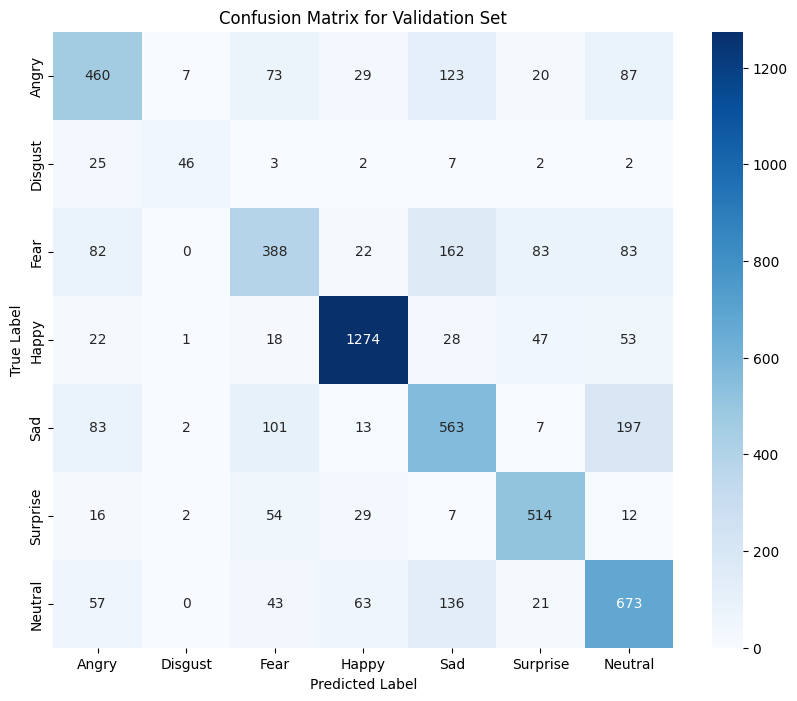

In [14]:
# Cell 8: Model Evaluation (on Validation Set)
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Evaluating on Validation Set"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

val_accuracy = accuracy_score(all_labels, all_preds)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=emotion_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Validation Set')
plt.show()

In [15]:
import wandb

# Start a new wandb run to track this model
run = wandb.init(
    # Set your wandb entity (replace with your username)
    entity="zeliz22-free-university-of-tbilisi-",
    # Set the wandb project
    project="Facial Expression Recognition Challenge",
    name="AdvancedEmotionNet",
    # Add tags to organize runs
    tags=["CNN", "facial-expression", "pytorch", "BatchNormalization"],
    # Track hyperparameters and run metadata
    config={
        "architecture": "CNN",
        "dataset": "FER2013",
        "epochs": epochs,
        "learning_rate": learning_rate,
        "optimizer": "Adam",
        "batch_size": batch_size,
        "epochs": 50,
        "image_size": "48x48",
    }
)

# Count model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Log the final model results based on your training output
run.log({
    "final_train_accuracy": 0.72,  # From your results: Train Acc: 60.90%
    "final_train_loss": 0.74,     # From your results: Train Loss: 1.0504
    "final_val_accuracy": 0.68,    # From your results: Val Acc: 62.03%
    "final_val_loss": 0.91,       # From your results: Val Loss: 1.0073
    "total_parameters": total_params,
    "trainable_parameters": trainable_params,
    "steps_per_epoch": len(train_loader),  # 359 batches as shown in your output
})

# Finish the run
run.finish()

print("Model results logged to WandB successfully!")

wandb: Currently logged in as: zeliz22 (zeliz22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


final_train_accuracy,▁
final_train_loss,▁
final_val_accuracy,▁
final_val_loss,▁
steps_per_epoch,▁
total_parameters,▁
trainable_parameters,▁
final_train_accuracy,0.72
final_train_loss,0.74
final_val_accuracy,0.68
final_val_loss,0.91


Model results logged to WandB successfully!
